In [23]:
from keras.layers import Conv1D, Input, Activation
from keras.models import Model
import scipy.signal as sp
import numpy as np
import tables
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [39]:
coeff_path='/media/taufiq/Data/heart_sound/feature/filterbankcoeff60.mat'
signal_path='/media/taufiq/Data/heart_sound/Heart_Sound/Physionet/training/training-a/a0001.wav'
coeff=tables.open_file(coeff_path)
b1=coeff.root.b2[:]
b1=np.hstack(b1)
b1=np.reshape(b1,[b1.shape[0],1,1])
print b1.shape
fs,data=wavfile.read(signal_path)

(61, 1, 1)


In [71]:
filtered=sp.lfilter(b1[:,0,0],[1],data[:2500])

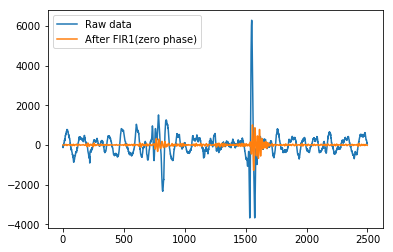

In [72]:
plt.plot(data[:2500],label='Raw data')
plt.plot(filtered,label='After FIR1(zero phase)')
plt.legend()
plt.show()

In [73]:
def FIRnet_w_act(input_size):
    input1=Input(shape=(input_size,1))
    x = Conv1D(1,61,use_bias=False,weights=[b1],padding='same') (input1)
    x = Activation(activation='relu') (x)
    model =Model(input1,x)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    
    return model

In [74]:
def FIRnet(input_size):
    input1=Input(shape=(input_size,1))
    x = Conv1D(1,61,use_bias=False, weights=[b1])(input1)
    model =Model(input1,x)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    
    return model

In [75]:
model = FIRnet(2500)
t = np.reshape(data[:2500],[1,2500,1])
new_data_ = model.predict(t)

In [76]:
model = FIRnet_w_act(2500)
t = np.reshape(data[:2500],[1,2500,1])
new_data = model.predict(t)

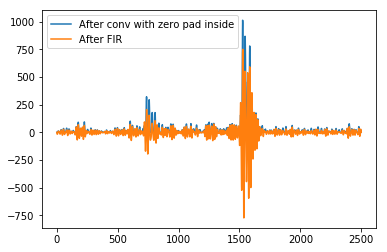

In [128]:
# plt.plot(new_data[0,:,0],label='After conv')
plt.plot(new_data[0,:,0],label='After conv with zero pad inside')
plt.plot(filtered,label='After FIR')
plt.legend()
plt.show()

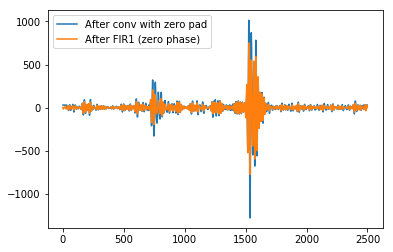

In [130]:
# plt.plot(new_data[0,:,0],label='After conv')
plt.plot(np.pad(new_data_[0,:,0],(30,30),'constant',constant_values=(30, 30)),label='After conv with zero pad')
plt.plot(filtered,label='After FIR1 (zero phase)')
plt.legend()
plt.show()

## Implementing filtfilt inside conv layer

In [24]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.engine.topology import InputSpec
import tensorflow as tf
import numpy as np
from keras.utils import conv_utils
from keras.layers import activations, initializers, regularizers, constraints

In [132]:
class Conv1D_zerophase(Layer):
    
    def __init__(self,filters,kernel_size,rank=1,strides=1,padding='valid',data_format='channels_last',dilation_rate=1,activation=None,use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,**kwargs):
        super(Conv1D_zerophase, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True


    def call(self, inputs):
        outputs = K.conv1d(
                inputs,
                self.kernel,
                strides=self.strides[0],
                padding='same',
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
        print tf.shape(outputs)
        outputs = tf.reverse(outputs,axis=[1])
        outputs = K.conv1d(
                outputs,
                self.kernel,
                strides=self.strides[0],
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
        print tf.shape(outputs)
        outputs = tf.reverse(outputs,axis=[1])
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        
        return outputs
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

        
    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Conv1D_zerophase, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [133]:
def FIRnet_zerophase(input_size):
    input1=Input(shape=(input_size,1))
    x = Conv1D_zerophase(1,61,use_bias=False, weights=[b1])(input1)
    model =Model(input1,x)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    
    return model

In [134]:
model = FIRnet_zerophase(2500)
t = np.reshape(data[:2500],[1,2500,1])
new_data_ = model.predict(t)
print new_data_

Tensor("conv1d_zerophase_20/Shape:0", shape=(3,), dtype=int32)
Tensor("conv1d_zerophase_20/Shape_1:0", shape=(3,), dtype=int32)
[[[ -8.50337887]
  [ -3.51722765]
  [  2.27529454]
  ..., 
  [ -5.42623615]
  [ -8.63265038]
  [-12.50613785]]]


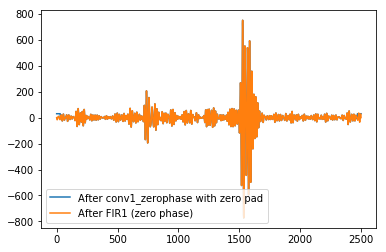

In [135]:
# plt.plot(new_data[0,:,0],label='After conv')
plt.plot(np.pad(new_data_[0,:,0],(30,30),'constant',constant_values=(30, 30)),label='After conv1_zerophase with zero pad')
plt.plot(filtered,label='After FIR1 (zero phase)')
plt.legend()
plt.show()

In [1]:
from keras.utils import conv_utils

Using TensorFlow backend.


In [22]:
kernel_size=60
if kernel_size%2:
    kernel_size = conv_utils.normalize_tuple(kernel_size/2+1,1,'kernel_size') 
else:
    kernel_size = conv_utils.normalize_tuple(kernel_size/2,1,'kernel_size')
print kernel_size[0]

30


## Linear Convolutional filter. Learns only half the filter

In [77]:
class Conv1D_zerophase_linear(Layer):
    
    def __init__(self,filters,kernel_size,rank=1,strides=1,padding='valid',data_format='channels_last',dilation_rate=1,activation=None,use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,**kwargs):
        super(Conv1D_zerophase_linear, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        if kernel_size%2:
            self.kernel_size = conv_utils.normalize_tuple(kernel_size/2+1,rank,'kernel_size') 
        else:
            self.kernel_size = conv_utils.normalize_tuple(kernel_size/2,rank,'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True


    def call(self, inputs):
        
        if self.kernel_size[0]%2==0:
            flipped = tf.reverse(self.kernel,axis=[0])
        else:
            flipped = tf.reverse(self.kernel[1:,:,:],axis=[0])
#         print (flipped)
        conv_kernel = tf.concat([flipped,self.kernel],axis=0)
#         print (conv_kernel)
        
        
        outputs = K.conv1d(
                inputs,
                conv_kernel,
                strides=self.strides[0],
                padding='same',
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
#         print tf.shape(outputs)
        outputs = tf.reverse(outputs,axis=[1])
        outputs = K.conv1d(
                outputs,
                conv_kernel,
                strides=self.strides[0],
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
#         print tf.shape(outputs)
        outputs = tf.reverse(outputs,axis=[1])
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        
        return outputs
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

        
    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Conv1D_zerophase_linear, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [78]:
def FIRnet_linearphase(input_size):
    input1=Input(shape=(input_size,1))
    x = Conv1D_linear(1,61,use_bias=False,weights=[b1[30:]])(input1)
    model =Model(input1,x)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    
    return model

In [79]:
model = FIRnet_linearphase(2500)
t = np.reshape(data[:2500],[1,2500,1])
new_data_ = model.predict(t)
print new_data_

Tensor("conv1d_linear_10/ReverseV2:0", shape=(30, 1, 1), dtype=float32)
Tensor("conv1d_linear_10/concat:0", shape=(61, 1, 1), dtype=float32)
[[[ -8.50337887]
  [ -3.51722765]
  [  2.27529454]
  ..., 
  [ -5.42623615]
  [ -8.63265038]
  [-12.50613785]]]


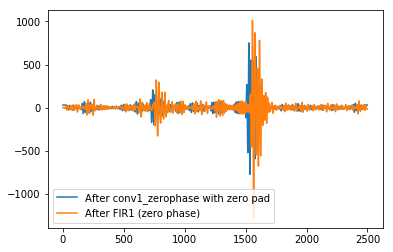

In [80]:
plt.plot(np.pad(new_data_[0,:,0],(30,30),'constant',constant_values=(30, 30)),label='After conv1_zerophase with zero pad')
plt.plot(filtered,label='After FIR1 (zero phase)')
plt.legend()
plt.show()